Choosing from all possible events


Torch Version: 2.2.2
GPU is NOT AVAILABLE
We try to set the tensorflow seeds, but it seems that tensorflow is not installed. Please refer to `https://www.tensorflow.org/` to install if you need to use this deep learning module.


/Users/kasperhenningsen/Desktop/moabb---Private-Encoder-Thesis-/moabb/datasets/preprocessing.py:279: UserWarning: warnEpochs <Epochs | 48 events (all good), 2 – 6 s (baseline off), ~8.1 MB, data loaded,
 'left_hand': 12
 'right_hand': 12
 'feet': 12
 'tongue': 12>
  warn(f"warnEpochs {epochs}")
/Users/kasperhenningsen/Desktop/moabb---Private-Encoder-Thesis-/moabb/datasets/preprocessing.py:279: UserWarning: warnEpochs <Epochs | 48 events (all good), 2 – 6 s (baseline off), ~8.1 MB, data loaded,
 'left_hand': 12
 'right_hand': 12
 'feet': 12
 'tongue': 12>
  warn(f"warnEpochs {epochs}")
/Users/kasperhenningsen/Desktop/moabb---Private-Encoder-Thesis-/moabb/datasets/preprocessing.py:279: UserWarning: warnEpochs <Epochs | 48 events (all good), 2 – 6 s (baseline off), ~8.1 MB, data loaded,
 'left_hand': 12
 'right_hand': 12
 'feet': 12
 'tongue': 12>
  warn(f"warnEpochs {epochs}")
/Users/kasperhenningsen/Desktop/moabb---Private-Encoder-Thesis-/moabb/datasets/preprocessing.py:279: UserWarning

  epoch    train_acc    train_loss    valid_acc    valid_loss     dur
-------  -----------  ------------  -----------  ------------  ------
      1       0.2711        1.3787       0.2874        1.3699  5.7171
      2       0.3153        1.3502       0.3321        1.3569  5.8303
      3       0.3771        1.3128       0.3502        1.3342  6.1194
      4       0.4115        1.2850       0.3829        1.3021  5.9350
      5       0.4360        1.2500       0.4614        1.2771  5.9597
      6       0.4507        1.2343       0.4312        1.2730  5.7844
      7       0.4712        1.2103       0.4565        1.2180  5.6207
      8       0.4828        1.1905       0.5000        1.1892  5.7316
      9       0.4770        1.1720       0.4758        1.1876  5.7798
     10       0.4966        1.1663       0.4807        1.1802  4.7265
     11       0.4936        1.1488       0.5048        1.1550  4.2545
     12       0.5126        1.1333       0.5036        1.1407  4.4171
     13       0.5159

BNCI2014-001-AllRuns: 100%|██████████| 1/1 [02:36<00:00, 156.56s/it]


      score        time  samples  cross_fold  n_test_samples subject session  \
0  0.647059  120.556526   4140.0         0.0            51.0       1  0train   
1  0.661538  120.556526   4140.0         0.0            65.0       1   1test   
2  0.228070  120.556526   4140.0         0.0            57.0       2  0train   
3  0.288136  120.556526   4140.0         0.0            59.0       2   1test   
4  0.698113  120.556526   4140.0         0.0            53.0       3  0train   

   channels  n_sessions       dataset             pipeline  
0        22           2  BNCI2014-001  CollapsedShallowNet  
1        22           2  BNCI2014-001  CollapsedShallowNet  
2        22           2  BNCI2014-001  CollapsedShallowNet  
3        22           2  BNCI2014-001  CollapsedShallowNet  
4        22           2  BNCI2014-001  CollapsedShallowNet  


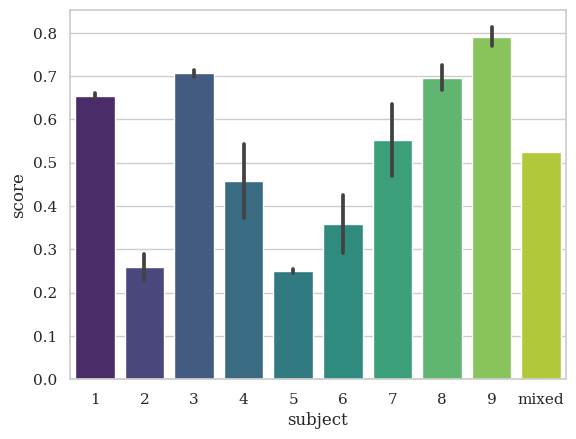

In [1]:
import matplotlib.pyplot as plt
import mne
import seaborn as sns
import torch
from braindecode import EEGClassifier
from sklearn.pipeline import make_pipeline
from skorch.callbacks import EarlyStopping, EpochScoring
from skorch.dataset import ValidSplit
from moabb.evaluations import AllRunsEvaluation, AllRunsEvaluationModified
from shallow import CollapsedShallowNet, CollapsedShallowNetPrivate

from moabb.datasets import BNCI2014_001
from moabb.evaluations import CrossSessionEvaluation
from moabb.paradigms import MotorImagery
from moabb.utils import setup_seed
    

mne.set_log_level(False)

# Print Information PyTorch
print(f"Torch Version: {torch.__version__}")

# Set up GPU if it is there
cuda = torch.cuda.is_available()
device = "cuda" if cuda else "cpu"
print("GPU is", "AVAILABLE" if cuda else "NOT AVAILABLE")

seed = 42
setup_seed(seed)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Hyperparameter
LEARNING_RATE = 0.0625 * 0.01  # parameter taken from Braindecode
WEIGHT_DECAY = 0  # parameter taken from Braindecode
BATCH_SIZE = 64  # parameter taken from BrainDecode
EPOCH = 20
PATIENCE = 3
fmin = 4
fmax = 100
tmin = 0
tmax = None


dataset = BNCI2014_001()
#events = ["right_hand", "left_hand"]
paradigm = MotorImagery(
    fmin=fmin, fmax=fmax, tmin=tmin, tmax=tmax
)
subjects = [1,2,3,4,5,6,7,8,9]
X, _, _ = paradigm.get_data(dataset=dataset, subjects=subjects)


# Define the CollapsedShallowNet model within the EEGClassifier
clf = EEGClassifier(
    module=CollapsedShallowNet,  # Use your model here
    module__n_chans=X.shape[1],  # number of input channels
    module__n_outputs=len(dataset.event_id),  # number of output classes
    module__n_times=X.shape[2],  # length of the input signal in time points
    optimizer=torch.optim.Adam,
    optimizer__lr=LEARNING_RATE,
    batch_size=BATCH_SIZE,
    max_epochs=EPOCH,
    train_split=ValidSplit(0.2, random_state=seed),
    device=device,
    callbacks=[
        EarlyStopping(monitor="valid_loss", patience=PATIENCE),
        EpochScoring(
            scoring="accuracy", on_train=True, name="train_acc", lower_is_better=False
        ),
        EpochScoring(
            scoring="accuracy", on_train=False, name="valid_acc", lower_is_better=False
        ),
    ],
    verbose=1,
)

# Create a pipeline with the classifier
pipes = {"CollapsedShallowNet": make_pipeline(clf)}

# Use the same CrossSessionEvaluation for training and evaluation
evaluation = AllRunsEvaluationModified(
    paradigm=paradigm,
    datasets=dataset,
    suffix="braindecode_collapsedshallownetprivate_example",
    overwrite=True,
    return_epochs=True,
    n_jobs=1,
)

# Run the evaluation process
results = evaluation.process(pipes)

# Display the results
print(results.head())

plt.figure()
sns.barplot(data=results, y="score", x="subject", palette="viridis")
plt.show()